## Víctor Cabré Guerrero


# Problema individual 2: ¿Original o traducción?

In [1]:
from apafib import load_translation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay,\
                            classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                            accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier


np.set_printoptions(threshold=100)

In [2]:
# Funcion hecha por Javier Bejar, extraida del notebook de la sesion 4 de laboratorio
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

In [3]:
# Cargamos los datos
data_tuple = load_translation()

Los datos se nos dan en una tupla con dos listas. En la primera lista hay los textos, y en la segunda lista están las categorías "Original" y "Translated" correspondientes a cada uno de los textos. Vamos a construir un DataFrame de manera que en cada fila tengamos el texto y su variable objetivo.

In [4]:
data = pd.DataFrame({"text":data_tuple[0], "target":data_tuple[1]})
data.head()

,text,target
0,"b""In they parted; the two youngest repaired to...",Original
1,b'Jane and tried to explain to her the nature ...,Original
2,"b'When this information was given, and they ha...",Original
3,"b'""Probably not; but can please where he choos...",Original
4,"b'Their visitors, except those from Park, were...",Original


In [5]:
data["target"].value_counts()

target
Original      300
Translated    300
Name: count, dtype: int64

La distribución de clases está perfectamente balanceada, así que no tendremos un problema de este tipo.

### Partición en datos de entrenamiento y test

Antes de preprocesar los datos, hacemos una partición en datos de entrenamiento y test.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["target"], test_size=0.2, random_state=77, stratify=data["target"].values)

### Preprocesado de los datos

Tenemos que aplicar la transformación de los vectorizers, generando cuatro conjuntos de datos diferentes:
1. Un conjunto con 2500 características donde se diga si la palabra aparece o no (binario)
2. Un conjunto con 2500 características donde se diga cuántas veces aparece la palabra (no binario)
3. Un conjunto con 5000 características donde se diga si la palabra aparece o no (binario)
4. Un conjunto con 5000 características donde se diga cuántas veces aparece la palabra (no binario)

Para hacerlo utilizaremos cuatro vectorizers diferentes, cada uno con los parámetros correspondientes. Si estamos preprocesando los datos de entrenamiento, entonces ajustaremos los vectorizers y haremos la transformación. Si estamos preprocesando los datos de test, únicamente haremos la transformación (el vectorizer ya estará ajustado por los datos de entrenamiento). De este modo, evitamos sesgar los datos.

In [7]:
def preprocesado(X, vectorizer_2500_binary=None, vectorizer_2500_non_binary=None, vectorizer_5000_binary=None, vectorizer_5000_non_binary=None):
    # Creamos y ajustamos los vectorizadores si no estan definidos ya
    if (vectorizer_2500_binary is None):
        vectorizer_2500_binary = CountVectorizer(stop_words="english", max_features=2500, binary=True).fit(X)
    if (vectorizer_2500_non_binary is None):
        vectorizer_2500_non_binary = CountVectorizer(stop_words="english", max_features=2500, binary=False).fit(X)
    if (vectorizer_5000_binary is None):
        vectorizer_5000_binary = CountVectorizer(stop_words="english", max_features=5000, binary=True).fit(X)
    if (vectorizer_5000_non_binary is None):
        vectorizer_5000_non_binary = CountVectorizer(stop_words="english", max_features=5000, binary=False).fit(X)
    
    # Transformamos los datos
    X_2500_binary = vectorizer_2500_binary.transform(X)
    X_2500_non_binary = vectorizer_2500_non_binary.transform(X)
    X_5000_binary = vectorizer_5000_binary.transform(X)
    X_5000_non_binary = vectorizer_5000_non_binary.transform(X)
    
    return X_2500_binary, X_2500_non_binary, X_5000_binary, X_5000_non_binary, vectorizer_2500_binary, vectorizer_2500_non_binary, vectorizer_5000_binary, vectorizer_5000_non_binary

In [8]:
# Para tener nombres de las variables mas cortos: el primer caracter es x (los datos) o v (el vectorizador), luego
# 25 (2500) o 50 (5000) de max_features, y finalmente b (binario) o nb (no binario / count).

X_25b, X_25nb, X_50b, X_50nb, v_25b, v_25nb, v_50b, v_50nb = preprocesado(X_train)

### Reducción de dimensionalidad y visualización mediante t-SNE

Usaremos t-SNE para reducir la dimensionalidad de los datos a dos dimensiones y así visualizarlos en 2D. Si las características de los datos son diferentes entre clases, es decir, que ejemplos de la misma clase se parecen bastante entre sí y ejemplos de diferentes clases no se parecen demasiado, podremos observar una separabilidad en las visualizaciones. Esto nos indicará que los ejemplos se comportan de forma diferente según la clase en la que están, lo que significa que probablemente sea sencillo entrenar un modelo con esos datos.

In [9]:
tsne_25b = TSNE(n_components=2, perplexity=30,n_iter=2000,init="random", n_jobs=-1)
tsne_25nb = TSNE(n_components=2, perplexity=30,n_iter=2000,init="random", n_jobs=-1)
tsne_50b = TSNE(n_components=2, perplexity=30,n_iter=2000, init="random", n_jobs=-1)
tsne_50nb = TSNE(n_components=2, perplexity=30,n_iter=2000, init="random", n_jobs=-1)

X_trans_25b = tsne_25b.fit_transform(X_25b.toarray())
X_trans_25nb = tsne_25nb.fit_transform(X_25nb.toarray())
X_trans_50b = tsne_50b.fit_transform(X_50b.toarray())
X_trans_50nb = tsne_50nb.fit_transform(X_50nb.toarray())

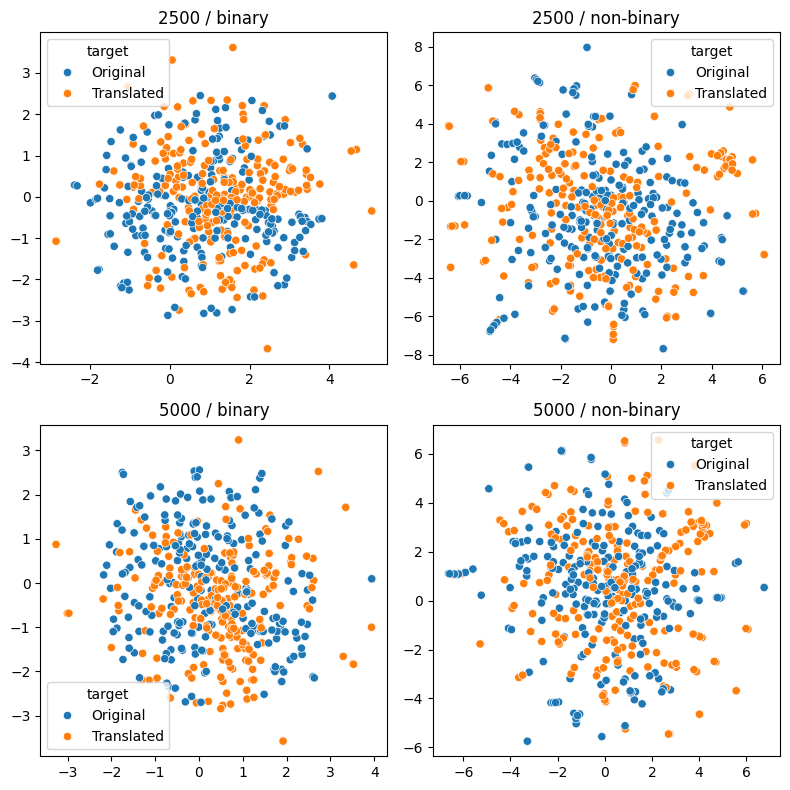

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

sns.scatterplot(x=X_trans_25b[:,0], y=X_trans_25b[:,1], hue=y_train, ax=axes[0,0]);
sns.scatterplot(x=X_trans_25nb[:,0], y=X_trans_25nb[:,1], hue=y_train, ax=axes[0,1]);
sns.scatterplot(x=X_trans_50b[:,0], y=X_trans_50b[:,1], hue=y_train, ax=axes[1,0]);
sns.scatterplot(x=X_trans_50nb[:,0], y=X_trans_50nb[:,1], hue=y_train, ax=axes[1,1]);

axes[0,0].set_title("2500 / binary")
axes[0,1].set_title("2500 / non-binary")
axes[1,0].set_title("5000 / binary")
axes[1,1].set_title("5000 / non-binary")

plt.tight_layout()

Como se puede observar en las gráficas anteriores, ninguna visualización muestra una separabilidad clara entre las  clases "Original" y "Translated". Es muy posible que nuestro conjunto de datos sea muy difícil de clasificar correctamente, aunque también tenemos que tener en cuenta que no necesariamente es así. Con el t-SNE estamos intentando reducir la dimensionalidad datos con muchas dimensiones (2500 y 5000). Esto, de por sí, es una tarea difícil, por lo que es posible que nuestro modelo pueda aprender patrones en los datos aunque no tengamos separabilidad entre clases en nuestras visualizaciones.

### Ajuste de Naïve Bayes

Vamos a intentar ajustar el modelo Naïve Bayes a nuestros datos. Entrenaremos un Naïve Bayes que siga una distribución de Bernoulli y otro Naïve Bayes que siga una distribución multinomial. Finalmente compararemos los resultados que nos dan ambos modelos.

#### Siguiendo una distribución de Bernoulli

In [11]:
bnb = BernoulliNB()

score_25b = np.mean(cross_val_score(bnb,X_25b,y_train,cv=10))
score_25nb = np.mean(cross_val_score(bnb,X_25nb,y_train,cv=10))
score_50b = np.mean(cross_val_score(bnb,X_50b,y_train,cv=10))
score_50nb = np.mean(cross_val_score(bnb,X_50nb,y_train,cv=10))

In [12]:
index = ["2500 / binary (Bernoulli)", "2500 / non-binary (Bernoulli)", "5000 / binary (Bernoulli)", "5000 / non-binary (Bernoulli)"]
results_bernoulli =pd.DataFrame({"CV score": [score_25b, score_25nb, score_50b, score_50nb]}, index=index).sort_values(by="CV score", ascending=False)

results_bernoulli

,CV score
5000 / binary (Bernoulli),0.833333
5000 / non-binary (Bernoulli),0.827083
2500 / non-binary (Bernoulli),0.816667
2500 / binary (Bernoulli),0.812500


Tenemos un acierto bastante bueno en todos los conjuntos de datos. El que más destaca es el conjunto donde tenemos 5000 características y utilizamos variables binarias (si la palabra aparece o no), con un 83.33% de acierto.

#### Siguiendo una distribución multinomial

In [13]:
bnb = MultinomialNB()

score_25b = np.mean(cross_val_score(bnb,X_25b,y_train,cv=10))
score_25nb = np.mean(cross_val_score(bnb,X_25nb,y_train,cv=10))
score_50b = np.mean(cross_val_score(bnb,X_50b,y_train,cv=10))
score_50nb = np.mean(cross_val_score(bnb,X_50nb,y_train,cv=10))

In [14]:
index = ["2500 / binary (multinomial)", "2500 / non-binary (multinomial)", "5000 / binary (multinomial)", "5000 / non-binary (multinomial)"]
results_multinomial = pd.DataFrame({"CV score": [score_25b, score_25nb, score_50b, score_50nb]}, index=index).sort_values(by="CV score", ascending=False)

results_multinomial

,CV score
5000 / non-binary (multinomial),0.847917
5000 / binary (multinomial),0.831250
2500 / non-binary (multinomial),0.820833
2500 / binary (multinomial),0.814583


In [15]:
results = pd.concat([results_bernoulli, results_multinomial])

results.sort_values(by="CV score", ascending=False)

,CV score
5000 / non-binary (multinomial),0.847917
5000 / binary (Bernoulli),0.833333
5000 / binary (multinomial),0.831250
5000 / non-binary (Bernoulli),0.827083
2500 / non-binary (multinomial),0.820833
2500 / non-binary (Bernoulli),0.816667
2500 / binary (multinomial),0.814583
2500 / binary (Bernoulli),0.812500


El resultado medio de validación cruzada siguiendo una distribución multinomial es mejor que con la distribución de Bernoulli. El mejor conjunto de datos es el que tiene 5000 características y atributos no binarios.

En ambos  casos, los conjuntos de datos con 5000 características han puntuado ligeramente mejor que los de 2500 características. La mejora en ambas distribuciones ha sido de dos puntos, aproximadamente, entre el modelo que mejor se comporta con 2500 atributos y el que mejor se comporta con 5000 atributos. Es posible que al haber más atributos el modelo pueda aprender más sobre los patrones subyacentes que hay en los datos, aunque es difícil decidir si realmente es así, ya que la diferencia no es grande.

Ahora vamos a ajustar los modelos para cada conjunto de datos. Para hacer la validación con los datos de test, primero vamos a preprocesar los datos de test usando la misma función que hemos usado para los datos de entrenamiento, pero ahora le pasamos los vectorizadores.

In [16]:
X_25b_test, X_25nb_test, X_50b_test, X_50nb_test, _, _, _, _ = preprocesado(X_test, v_25b, v_25nb, v_50b, v_50nb)

results_bernoulli_df = pd.DataFrame()
results_multinomial_df = pd.DataFrame()
results_all_df = pd.DataFrame()

#### Siguiendo una distribución de Bernoulli

In [17]:
# 2500 / binary

bnb_model_25b = BernoulliNB().fit(X_25b, y_train)
print(classification_report(bnb_model_25b.predict(X_25b_test), y_test, target_names=["Original", "Translated"]))
results_bernoulli_df = save_results(bnb_model_25b, X_25b_test, y_test, "2500 / binary (Bernoulli)", results_bernoulli_df)

              precision    recall  f1-score   support

    Original       0.77      0.78      0.77        59
  Translated       0.78      0.77      0.78        61

    accuracy                           0.78       120
   macro avg       0.78      0.78      0.77       120
weighted avg       0.78      0.78      0.78       120



In [18]:
# 2500 / non-binary

bnb_model_25nb = BernoulliNB().fit(X_25nb, y_train)
print(classification_report(bnb_model_25nb.predict(X_25nb_test), y_test, target_names=["Original", "Translated"]))
results_bernoulli_df = save_results(bnb_model_25nb, X_25nb_test, y_test, "2500 / non-binary (Bernoulli)", results_bernoulli_df)

              precision    recall  f1-score   support

    Original       0.77      0.79      0.78        58
  Translated       0.80      0.77      0.79        62

    accuracy                           0.78       120
   macro avg       0.78      0.78      0.78       120
weighted avg       0.78      0.78      0.78       120



In [19]:
# 5000 / binary

bnb_model_50b = BernoulliNB().fit(X_50b, y_train)
print(classification_report(bnb_model_50b.predict(X_50b_test), y_test, target_names=["Original", "Translated"]))
results_bernoulli_df = save_results(bnb_model_50b, X_50b_test, y_test, "5000 / binary (Bernoulli)", results_bernoulli_df)

              precision    recall  f1-score   support

    Original       0.82      0.86      0.84        57
  Translated       0.87      0.83      0.85        63

    accuracy                           0.84       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120



In [20]:
# 5000 / non-binary

bnb_model_50nb = BernoulliNB().fit(X_50nb, y_train)
print(classification_report(bnb_model_50nb.predict(X_50nb_test), y_test, target_names=["Original", "Translated"]))
results_bernoulli_df = save_results(bnb_model_50nb, X_50nb_test, y_test, "5000 / non-binary (Bernoulli)", results_bernoulli_df)

              precision    recall  f1-score   support

    Original       0.82      0.86      0.84        57
  Translated       0.87      0.83      0.85        63

    accuracy                           0.84       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120



In [21]:
results_bernoulli_df.sort_values(by="f1 score (W)", ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
5000 / binary (Bernoulli),0.841667,0.842523,0.841667,0.841568
5000 / non-binary (Bernoulli),0.841667,0.842523,0.841667,0.841568
2500 / non-binary (Bernoulli),0.783333,0.783648,0.783333,0.783273
2500 / binary (Bernoulli),0.775000,0.775076,0.775000,0.774984


La validación de nuestros modelos de Naïve Bayes usando Bernoulli con el conjunto de test da resultados muy buenos en todos los casos. De nuevo, los procesado con 5000 características dan mejores resultados que con 2500. Las diferencias entre tener un contador de apariciones (non-binary) o un booleano que nos diga si la palabra aparece o no (binary) no parece afectar mucho a los resultados.

Los resultados con 5000 características nos han dado una precisión del 84%, un recall del 84% y un f1 score del 84%. Comparando estos valores con los obtenidos en la validación cruzada con los datos de entrenamiento, podemos ver que el modelo ha aprendido bien los patrones de los datos y que no ha habido overfitting.

#### Siguiendo una distribución multinomial

In [22]:
# 2500 / binary

mnb_model_25b = MultinomialNB().fit(X_25b, y_train)
print(classification_report(mnb_model_25b.predict(X_25b_test), y_test, target_names=["Original", "Translated"]))
results_multinomial_df = save_results(mnb_model_25b, X_25b_test, y_test, "2500 / binary (Multinomial)", results_multinomial_df)

              precision    recall  f1-score   support

    Original       0.82      0.80      0.81        61
  Translated       0.80      0.81      0.81        59

    accuracy                           0.81       120
   macro avg       0.81      0.81      0.81       120
weighted avg       0.81      0.81      0.81       120



In [23]:
# 2500 / non-binary

mnb_model_25nb = MultinomialNB().fit(X_25nb, y_train)
print(classification_report(mnb_model_25nb.predict(X_25nb_test), y_test, target_names=["Original", "Translated"]))
results_multinomial_df = save_results(mnb_model_25nb, X_25nb_test, y_test, "2500 / non-binary (Multinomial)", results_multinomial_df)

              precision    recall  f1-score   support

    Original       0.85      0.85      0.85        60
  Translated       0.85      0.85      0.85        60

    accuracy                           0.85       120
   macro avg       0.85      0.85      0.85       120
weighted avg       0.85      0.85      0.85       120



In [24]:
# 5000 / binary

mnb_model_50b = MultinomialNB().fit(X_50b, y_train)
print(classification_report(mnb_model_50b.predict(X_50b_test), y_test, target_names=["Original", "Translated"]))
results_multinomial_df = save_results(mnb_model_50b, X_50b_test, y_test, "5000 / binary (Multinomial)", results_multinomial_df)

              precision    recall  f1-score   support

    Original       0.82      0.86      0.84        57
  Translated       0.87      0.83      0.85        63

    accuracy                           0.84       120
   macro avg       0.84      0.84      0.84       120
weighted avg       0.84      0.84      0.84       120



In [25]:
# 5000 / non-binary

mnb_model_50nb = MultinomialNB().fit(X_50nb, y_train)
print(classification_report(mnb_model_50nb.predict(X_50nb_test), y_test, target_names=["Original", "Translated"]))
results_multinomial_df = save_results(mnb_model_50nb, X_50nb_test, y_test, "5000 / non-binary (Multinomial)", results_multinomial_df)

              precision    recall  f1-score   support

    Original       0.87      0.90      0.88        58
  Translated       0.90      0.87      0.89        62

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.88       120
weighted avg       0.88      0.88      0.88       120



In [26]:
results_multinomial_df.sort_values(by="f1 score (W)", ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
5000 / non-binary (Multinomial),0.883333,0.883760,0.883333,0.883301
2500 / non-binary (Multinomial),0.850000,0.850000,0.850000,0.850000
5000 / binary (Multinomial),0.841667,0.842523,0.841667,0.841568
2500 / binary (Multinomial),0.808333,0.808419,0.808333,0.808320


Observamos en la tabla comparativa que todos los resultados son muy buenos. El peor modelo en este caso ha sido el que hemos entrenado con el conjunto de datos con 2500 características y atributos binarios. El mejor modelo es el de 5000 características no binario, que destaca 3 puntos por sobre del segundo mejor modelo con una precision, recall y f1 score entorno al 88%.

Con la distribución multinomial, los modelos no binarios han dado mejores resultados que los modelos binarios, y parece que el número de características no es tan importante.

#### Comparativa de resultados

In [27]:
results_all_df = pd.concat([results_bernoulli_df, results_multinomial_df])
results_all_df.sort_values(by="f1 score (W)", ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
5000 / non-binary (Multinomial),0.883333,0.883760,0.883333,0.883301
2500 / non-binary (Multinomial),0.850000,0.850000,0.850000,0.850000
5000 / binary (Bernoulli),0.841667,0.842523,0.841667,0.841568
5000 / non-binary (Bernoulli),0.841667,0.842523,0.841667,0.841568
5000 / binary (Multinomial),0.841667,0.842523,0.841667,0.841568
2500 / binary (Multinomial),0.808333,0.808419,0.808333,0.808320
2500 / non-binary (Bernoulli),0.783333,0.783648,0.783333,0.783273
2500 / binary (Bernoulli),0.775000,0.775076,0.775000,0.774984


El mejor resultado, que destaca bastante por encima de todos los demás, es el modelo Naïve Bayes con distribución multinomial, utilizando el conjunto de datos con 5000 características y datos no binarios. Este es el modelo que elegiríamos si tuvieramos que utilizar Naïve Bayes. Entre los demás, el peor con diferencia es el que utiliza una distribución de Bernoulli con los datos de 2500 características y datos binarios. Los demás modelos son bastante parecidos, y tanto BernoulliNB como MultinomialNB producen resultados similares. En general, BernoulliNB parece que se comporta mejor con 5000 características, independientemente de los tipos de los datos (binario o no binario), mientras que MultinomialNB se comporta mejor con datos no binarios.

A continuación, estudiaremos únicamente nuestro mejor modelo: el modelo Naïve Bayes con distribución multinomial, utilizando el conjunto de datos con 5000 características y datos no binarios.

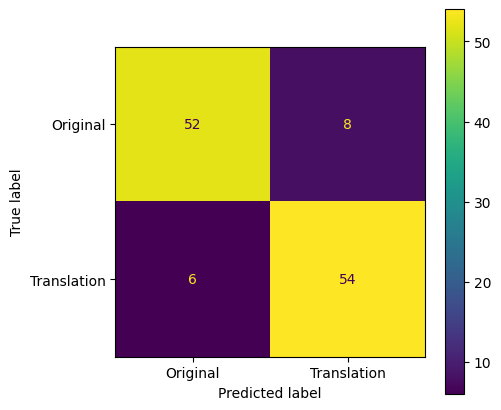

In [28]:
plt.figure(figsize=(5,5));
ConfusionMatrixDisplay.from_estimator(mnb_model_50nb, X_50nb_test,y_test, display_labels=["Original", "Translation"], ax=plt.subplot());

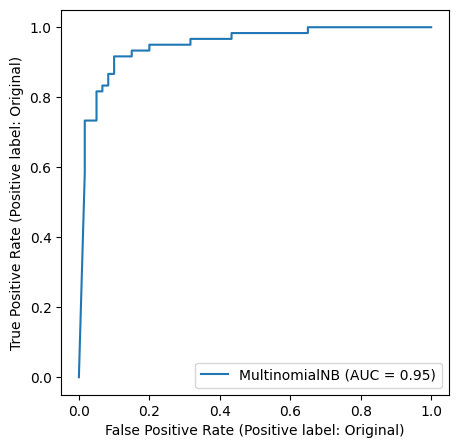

In [29]:
plt.figure(figsize=(5,5));
RocCurveDisplay.from_estimator(mnb_model_50nb, X_50nb_test, y_test, pos_label="Original", ax=plt.subplot());

Vemos que nuestro mejor modelo de Naïve Bayes es bastante bueno en los datos de test. Su precision y recall es muy parecido, de manera que no hay una desproporción entre aciertos en una clase y en otra. En la matriz de confusión podemos ver que los ejemplos se distribuyen en la diagonal de forma equilibrada. De 120 ejemplos del conjunto de datos de test, 106 se clasifican correctamente, 8 se clasifican como "Translation" cuando deberían ser clasificados como "Original", y 6 se clasifican incorrectamente como "Original".

En la ROC Curve observamos que la curva está bastante cerca del margen superior izquierdo (si estuviera pegada a este margen, significaría que tendriamos un True Positive Rate de 100% con un False Positive Rate del 0%, que sería el caso ideal). El área bajo la curva es de 0.95, también muy buena. Cuanto más cercana al 1, que es el valor máximo y el valor ideal, mejor.

### Ajuste de K-Nearest Neighbors

Antes de ajustar el modelo KNN a nuestros datos, haremos una búsqueda entre los hiperparámetros para encontrar el conjunto que dé los mejores resultados. Esto lo podemos hacer con GridSearchCV, que hace una búsqueda exhaustiva probando todos los subconjuntos posibles de hiperparámetros.

Este proceso lo haremos sobre cada conjunto de datos preprocesados diferente (2500/5000 características y binary/non-binary).

In [30]:
results_KNN = pd.DataFrame()

#### 2500 / binary

In [31]:
knn_classifier = KNeighborsClassifier()

param = {"n_neighbors":[1,2,3,4,5,6,7,8,9,10,13,15,20,30],"weights":["uniform", "distance"], "p":[1,2]}
knn_gs_25b =  GridSearchCV(knn_classifier,param,cv=5, n_jobs=-1, refit=True)
knn_gs_25b.fit(X_25b, y_train);

pd.DataFrame(knn_gs_25b.cv_results_).loc[:,['params', 'mean_test_score']].sort_values(by="mean_test_score", ascending=False).head()

,params,mean_test_score
28,"{'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}",0.652083
7,"{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}",0.652083
50,"{'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}",0.652083
48,"{'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}",0.652083
30,"{'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}",0.652083


Ahora que tenemos nuestro conjunto de parámetros decidido, vamos a ver como funciona el modelo haciendo validación con los datos de test.

In [32]:
print(classification_report(knn_gs_25b.predict(X_25b_test), y_test, target_names=["Original", "Translated"]))
results_KNN = save_results(knn_gs_25b, X_25b_test, y_test, '2500 / binary', results_KNN)

              precision    recall  f1-score   support

    Original       0.47      0.61      0.53        46
  Translated       0.70      0.57      0.63        74

    accuracy                           0.58       120
   macro avg       0.58      0.59      0.58       120
weighted avg       0.61      0.58      0.59       120



#### 2500 / non-binary

In [33]:
knn_classifier = KNeighborsClassifier()

param = {"n_neighbors":[1,2,3,4,5,6,7,8,9,10,13,15,20,30],"weights":["uniform", "distance"], "p":[1,2]}
knn_gs_25nb =  GridSearchCV(knn_classifier,param,cv=5, n_jobs=-1, refit=True)
knn_gs_25nb.fit(X_25nb, y_train);

pd.DataFrame(knn_gs_25nb.cv_results_).loc[:,['params', 'mean_test_score']].sort_values(by="mean_test_score", ascending=False).head()



,params,mean_test_score
14,"{'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}",0.693750
38,"{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}",0.691667
6,"{'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}",0.691667
30,"{'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}",0.681250
20,"{'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}",0.664583


In [34]:
print(classification_report(knn_gs_25nb.predict(X_25nb_test), y_test, target_names=["Original", "Translated"]))
results_KNN = save_results(knn_gs_25nb, X_25nb_test, y_test, '2500 / non-binary', results_KNN)

              precision    recall  f1-score   support

    Original       0.63      0.78      0.70        49
  Translated       0.82      0.69      0.75        71

    accuracy                           0.73       120
   macro avg       0.72      0.73      0.72       120
weighted avg       0.74      0.72      0.73       120



#### 5000 / binary

In [35]:
knn_classifier = KNeighborsClassifier()

param = {"n_neighbors":[1,2,3,4,5,6,7,8,9,10,13,15,20,30],"weights":["uniform", "distance"], "p":[1,2]}
knn_gs_50b =  GridSearchCV(knn_classifier,param,cv=5, n_jobs=-1, refit=True)
knn_gs_50b.fit(X_50b, y_train);

pd.DataFrame(knn_gs_50b.cv_results_).loc[:,['params', 'mean_test_score']].sort_values(by="mean_test_score", ascending=False).head()



,params,mean_test_score
20,"{'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}",0.627083
22,"{'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}",0.627083
38,"{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}",0.618750
36,"{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}",0.618750
4,"{'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}",0.616667


In [36]:
print(classification_report(knn_gs_50b.predict(X_50b_test), y_test, target_names=["Original", "Translated"]))
results_KNN = save_results(knn_gs_50b, X_50b_test, y_test, '5000 / binary', results_KNN)

              precision    recall  f1-score   support

    Original       0.37      0.73      0.49        30
  Translated       0.87      0.58      0.69        90

    accuracy                           0.62       120
   macro avg       0.62      0.66      0.59       120
weighted avg       0.74      0.62      0.64       120



#### 5000 / non-binary

In [37]:
knn_classifier = KNeighborsClassifier()

param = {"n_neighbors":[1,2,3,4,5,6,7,8,9,10,13,15,20,30],"weights":["uniform", "distance"], "p":[1,2]}
knn_gs_50nb =  GridSearchCV(knn_classifier,param,cv=5, n_jobs=-1, refit=True)
knn_gs_50nb.fit(X_50nb, y_train);

pd.DataFrame(knn_gs_50nb.cv_results_).loc[:,['params', 'mean_test_score']].sort_values(by="mean_test_score", ascending=False).head()



,params,mean_test_score
22,"{'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}",0.687500
14,"{'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}",0.687500
6,"{'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}",0.679167
30,"{'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}",0.679167
38,"{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}",0.672917


In [38]:
print(classification_report(knn_gs_50nb.predict(X_50b_test), y_test, target_names=["Original", "Translated"]))
results_KNN = save_results(knn_gs_50nb, X_50nb_test, y_test, '5000 / non-binary', results_KNN)

              precision    recall  f1-score   support

    Original       0.88      0.52      0.65       102
  Translated       0.18      0.61      0.28        18

    accuracy                           0.53       120
   macro avg       0.53      0.57      0.47       120
weighted avg       0.78      0.53      0.60       120



#### Análisis de los resultados con KNN

In [39]:
results_KNN.sort_values(by="f1 score (W)", ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
2500 / non-binary,0.725000,0.732826,0.725000,0.722670
5000 / non-binary,0.666667,0.683150,0.666667,0.658994
5000 / binary,0.616667,0.655556,0.616667,0.591111
2500 / binary,0.583333,0.588132,0.583333,0.577584


Como se puede ver en la tabla superior, hay un modelo que destaca por encima de los demás. Este es el modelo que utiliza los datos preprocesados con 2500 características y valores no binarios. Además, el modelo entrenado con estos datos utiliza los siguientes hiperparámetros:

In [40]:
knn_gs_25nb.best_params_

{'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}

In [41]:
print(classification_report(knn_gs_25nb.predict(X_25nb_test), y_test, target_names=["Original", "Translated"]))

              precision    recall  f1-score   support

    Original       0.63      0.78      0.70        49
  Translated       0.82      0.69      0.75        71

    accuracy                           0.73       120
   macro avg       0.72      0.73      0.72       120
weighted avg       0.74      0.72      0.73       120



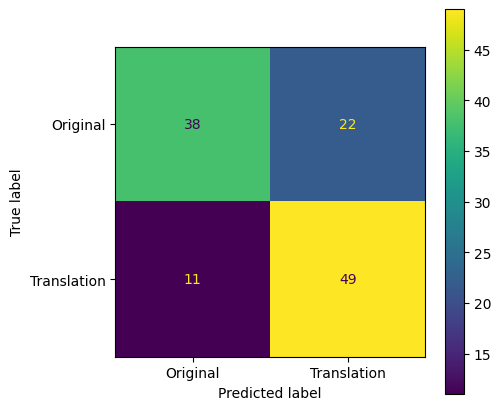

In [42]:
plt.figure(figsize=(5,5));
ConfusionMatrixDisplay.from_estimator(knn_gs_25nb, X_25nb_test, y_test, display_labels=["Original", "Translation"], ax=plt.subplot());

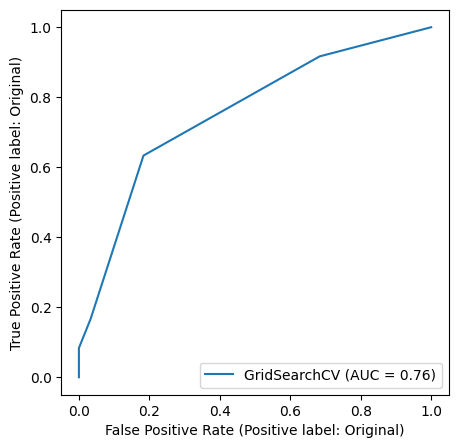

In [43]:
plt.figure(figsize=(5,5));
RocCurveDisplay.from_estimator(knn_gs_25nb, X_25nb_test, y_test, pos_label="Original", ax=plt.subplot());

Como podemos ver, el modelo no es demasiado bueno. El modelo clasifica incorrectamente muchos de los ejemplos. Para la clase "Original", su valor de precisión es del 63%, lo que significa que de los ejemplos que ha clasificado como "Original", solamente el 63% lo son. Dicho de otra manera, se equivoca en el 37% de los casos en que clasifica como "Original".La clase "Translation" tiene mejor precisión pero sacrifica en recuperación. Hay muchos ejemplos que no se clasifican como "Translation" cuando deberían serlo. En contraposición, la mayor parte de los ejemplos que son de la clase "Translation" se clasifican acordemente. Aquí hay un compromiso entre la recuperación y la precisión. Dependiendo de la tarea, nos importará más no equivocarnos diciendo que es una traducción que encontrar todas las traducciones. La ROC curve, con un área bajo la curva de 0.76, ya muestra que a medida que se incrementa el True Positive Rate, el False Positive Rate augmenta considerablemente. Es una curva bastante mala, ya que se aleja mucho del márgen superior izquierdo.

### Selección del mejor modelo

In [44]:
cols = results_all_df.sort_values(by="f1 score (W)", ascending=False).iloc[0].index.tolist()

best_model_NB = results_all_df.sort_values(by="f1 score (W)", ascending=False).iloc[0].tolist()
best_model_KNN = results_KNN.sort_values(by="f1 score (W)", ascending=False).iloc[0].tolist()

df_NB = pd.DataFrame([best_model_NB], columns=cols, index=['Mejor modelo Naïve Bayes (5000 / non-binary (Multinomial))'])
df_KNN = pd.DataFrame([best_model_KNN], columns=cols, index=['Mejor modelo KNN (2500 / non-binary)'])

final_results = pd.concat([df_NB, df_KNN])

final_results.sort_values(by="f1 score (W)", ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
Mejor modelo Naïve Bayes (5000 / non-binary (Multinomial)),0.883333,0.883760,0.883333,0.883301
Mejor modelo KNN (2500 / non-binary),0.725000,0.732826,0.725000,0.722670


Comparando el mejor modelos que hemos obtenido usando Naïve Bayes y KNN vemos que el Naïve Bayes da mucho mejores resultados, unos 16 puntos por encima que los del KNN en términos de f1 score. El modelo NB clasifica mucho mejor los resultados y tiene un True Positive Rate muy alto que alcanza con un False Positive Rate muy reducido. No solo es mejor en términos de precisión, sino que además su recuperación en ambas clases es muy superior.
En definitiva, no tendría sentido utilizar el mejor modelo de KNN en este caso de uso. Su rendimiento es muy inferior y además es un poco más costoso computacionalmente. En las figuras de abajo (que son las mismas que las mostradas en el apartado de Naïve Bayes (Multinomial)), vemos que efectivamente es mucho mejor a las que acabamos de ver con el mejor modelo de KNN.

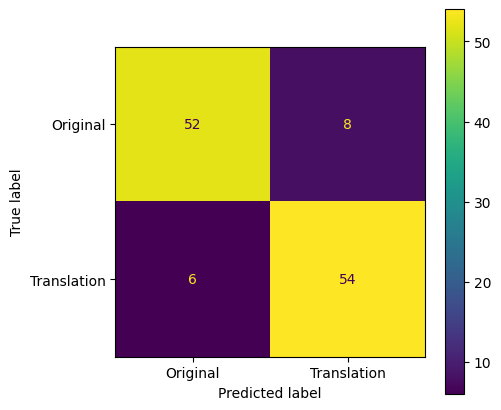

In [45]:
plt.figure(figsize=(5,5));
ConfusionMatrixDisplay.from_estimator(mnb_model_50nb, X_50nb_test,y_test, display_labels=["Original", "Translation"], ax=plt.subplot());

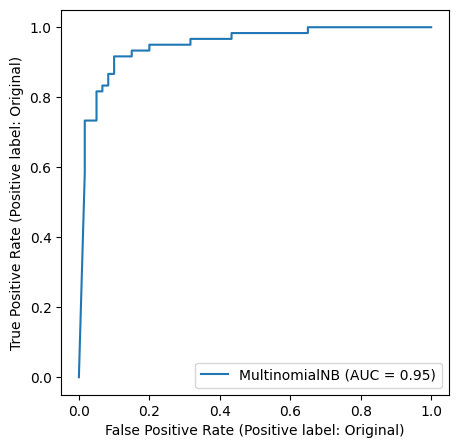

In [46]:
plt.figure(figsize=(5,5));
RocCurveDisplay.from_estimator(mnb_model_50nb, X_50nb_test, y_test, pos_label="Original", ax=plt.subplot());